# Simple Linear Regression on Crypto

In [206]:
import pandas as pd
import yfinance as yf
from ta import add_all_ta_features
from datetime import datetime, timedelta
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go

# 1. Get Price Data

In [413]:
def getCryptoPrice(ticker="BTC-USD", n_days=1000):

    # Time periods
    now = datetime.now()

    # How far back to retrieve
    ago = now - timedelta(days=n_days)

    # Designating the Ticker
    crypto = yf.Ticker(ticker)

    # Getting price history
    df = crypto.history(
        start=ago.strftime("%Y-%m-%d"), 
        end=now.strftime("%Y-%m-%d"), 
        interval="1d"
    )

    # Dropping Columns
    df.drop(
        ['Dividends', 'Stock Splits'], 
        axis=1,
        inplace=True
    )

    return df

In [414]:
df = getCryptoPrice(ticker="BTC-USD", n_days=400)

df

,Open,High,Low,Close,Volume
Date,,,,,
2020-09-05,10512.530273,10581.571289,9946.675781,10169.567383,44916565292
2020-09-06,10167.216797,10353.927734,10056.885742,10280.351562,37071460174
2020-09-07,10280.998047,10399.153320,9916.493164,10369.563477,33703098409
2020-09-08,10369.306641,10414.775391,9945.110352,10131.516602,33430927462
2020-09-09,10134.151367,10350.542969,10017.250977,10242.347656,24128292755
...,...,...,...,...,...
2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500,35873904236
2021-10-06,51486.664062,55568.464844,50488.191406,55361.449219,49034730168
2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375,36807860413


## Adding Technical Indicators

In [415]:
df = add_all_ta_features(
    df, 
    open="Open", 
    high="High", 
    low="Low", 
    close="Close", 
    volume="Volume", 
    fillna=True
)

df

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-05,10512.530273,10581.571289,9946.675781,10169.567383,44916565292,-1.337901e+10,44916565292,-0.297864,0.000000e+00,50.000000,...,-64.893183,0.000000,10169.567383,0.000000,0.000000,0.000000,0.000000,-72.012439,0.000000,0.000000
2020-09-06,10167.216797,10353.927734,10056.885742,10280.351562,37071460174,5.327528e+09,81988025466,0.064979,4.106931e+12,0.000000,...,-47.443985,0.000000,10205.793051,0.000000,-1.411558,-0.282312,-1.129246,1.089370,1.083479,1.089370
2020-09-07,10280.998047,10399.153320,9916.493164,10369.563477,33703098409,3.489824e+10,115691123875,0.301650,3.949758e+12,0.000000,...,-31.877129,0.000000,10257.926199,0.000000,-3.163656,-0.858580,-2.305076,0.867790,0.864047,1.966614
2020-09-08,10369.306641,10414.775391,9945.110352,10131.516602,33430927462,2.800424e+10,82260196413,0.187794,2.248631e+12,0.000000,...,-67.669447,0.000000,10216.675510,0.000000,-4.609510,-1.608766,-3.000744,-2.295631,-2.322391,-0.374163
2020-09-09,10134.151367,10350.542969,10017.250977,10242.347656,24128292755,3.646718e+10,106388489168,0.210488,2.309422e+12,18.793719,...,-51.005080,0.000000,10225.331336,0.000000,-7.626736,-2.812360,-4.814376,1.093924,1.087984,0.715667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500,35873904236,2.613914e+12,1115249326898,0.081922,2.944481e+13,78.889292,...,-2.899605,1961.426907,47241.756324,14.744850,-2.400365,-2.276192,-0.124173,4.890589,4.774761,406.558544
2021-10-06,51486.664062,55568.464844,50488.191406,55361.449219,49034730168,2.658952e+12,1164284057066,0.144615,5.218395e+13,79.855664,...,-1.404563,3287.652045,49169.287639,29.229160,1.350263,-1.550901,2.901164,7.467050,7.201410,444.383523
2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375,36807860413,2.633534e+12,1127476196653,0.120924,3.655005e+13,80.283588,...,-11.958103,4459.662408,50124.380268,25.960381,1.455792,-0.949562,2.405355,-2.809653,-2.849879,429.088233


# 2. Data Transformation/Preprocessing
Changing from time-series data to tabular data.

__E.g.)__ An N% increase in Volume _from N days ago to today_ leads to N% increase in the Open price in the _next_ N day(s). 

In [443]:
def transformData(df, days=1):
    """
    Transforming data into X variables for training.  Uses percent change and 
    multiplies the percentage by 100 rounded to 2 decimal places.
    """
    # Transforming data
    new_df = df.pct_change(
        days
    ).apply(
        lambda x: round(x*100, 2)
    ).replace(
        [np.inf, -np.inf], 
        np.nan
    )
    
    # Dropping Nans
    new_df = new_df.dropna(
        thresh=round(new_df.shape[1]*.7) # If 70% of the values in the row are Nans, drop the whole row
    ).dropna(
        axis=1,
        thresh=round(new_df.shape[0]*.7) # If 70% of the values in the columns are Nans, drop the whole column
    )
    
    # What the percent change is going to be in the next days AKA the Y Variable
    new_df[f'future_{days}_days']= df['Open'].pct_change(
        days
    ).shift(
        -days
    ).apply(
        lambda x: round(x*100, 2)
    )
    
    # Saving the last value in the dataset for later
    last_val = new_df.tail(1).drop(f'future_{days}_days',
                                   axis=1)

    # Dropping the last NaNs from the Y variable
    new_df = new_df.dropna(
        subset=[f'future_{days}_days']
    )

    # Filling in the rest of the NaNs with the most recent value
    new_df = new_df.fillna(method='ffill').dropna()

    return new_df, last_val

In [444]:
new_df, last_val = transformData(df, days=1)

new_df

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,future_1_days
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-03,-0.38,-0.46,0.84,-0.19,-26.09,-1.65,-9.78,26.40,-3.10,-3.21,...,-36.85,-0.14,-130.57,8.18,0.45,-132.91,-48.27,-48.32,-4.73,-0.15
2020-10-04,-0.15,0.82,0.03,1.13,2.65,10.82,11.12,-3.62,-85.94,17.50,...,-34.05,-0.01,40.37,4.58,1.29,187.76,-705.75,-701.81,30.04,1.14
2020-10-05,1.14,0.96,1.09,1.12,10.48,13.36,11.06,30.81,-580.28,17.73,...,-24.05,0.00,308.18,-0.97,0.82,-35.98,-0.58,-0.58,23.22,1.05
2020-10-06,1.05,-0.01,-0.76,-1.69,14.86,-7.12,-11.43,-23.81,-220.69,0.34,...,-15.82,-0.04,-120.39,-7.71,-0.94,-216.64,-250.80,-252.94,-28.74,-1.67
2020-10-07,-1.67,-1.08,0.25,0.54,-20.80,9.58,10.23,7.98,-56.98,1.62,...,43.11,-0.02,-81.24,2.91,-0.20,-78.75,-132.06,-131.70,12.71,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-04,1.11,0.66,-0.24,1.89,25.32,0.93,3.19,-17.59,9.58,14.04,...,-163.50,1.13,-31.09,-9.74,13.50,-36.89,85.01,84.21,2.40,2.00
2021-10-05,2.00,4.82,4.31,4.89,7.46,1.06,3.32,13.32,47.29,13.37,...,291.57,2.27,16.01,-27.56,1.38,-88.38,158.20,154.47,6.17,4.70
2021-10-06,4.70,7.19,2.88,7.47,36.69,1.72,4.40,76.53,77.23,1.22,...,67.62,4.08,98.23,-156.25,-31.86,-2436.39,52.68,50.82,9.30,7.48


In [450]:
# To be used for current prediction
last_val

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-09,0.24,-0.94,0.09,1.85,-6.64,0.6,2.8,60.92,0.16,6.84,...,-51.17,20.34,2.08,21.07,-77.16,-29.02,-60.98,516.18,511.46,2.28


# 3. Fit to Linear Model

In [451]:
# Column name
col_name = new_df.columns[-1]

# Train, test, split
X = new_df.drop(col_name, axis=1)

y = new_df[[col_name]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20
)

In [453]:
# Model object
reg = LinearRegression()

# Fitting
reg.fit(X_train, y_train)

# Getting predictions
preds = reg.predict(X_test)

In [454]:
# Testing current prediction
reg.predict(last_val)

array([[0.55990731]])

## Evaluation

In [455]:
# RMSE
print("RMSE:",mean_squared_error(
    y_test, 
    preds, 
    squared=False
))

# Coefficients
print("Coefficients:\n", reg.coef_)

# Intercept
print("Intercept:", reg.intercept_)

RMSE: 2.263186545962376
Coefficients:
 [[-9.76863499e-02  1.57262801e-01  1.24433445e-01  7.76406009e-01
   1.92752022e-02  5.31131654e-02 -4.14603424e-02  2.44957618e-04
   6.64540905e-04  1.28379012e-02  1.77848777e-05 -6.35829176e-04
   3.29385434e-04 -2.82043502e-02  8.64345501e-02  1.10628451e-03
  -5.45977082e-02 -6.06566962e-02 -3.11789381e-02  1.42598843e-02
   4.06055312e-04 -2.85275228e-02 -4.67697872e-02 -3.06144799e-03
  -6.25479504e-03  7.72245043e-05  1.19318225e-01 -1.12792176e-01
  -4.30068627e-02  3.82033432e-02 -3.49665626e-03 -8.32589958e-04
   7.06236222e-03 -1.82225001e-02 -3.60126012e-04  1.11181119e-01
  -7.77603162e-02  1.30314925e-01  3.15346361e-02  9.83850869e-03
   1.85419464e-03 -8.30953867e-03 -8.85392448e-03 -1.46211587e-02
  -6.44465649e-04 -7.20247641e-03 -1.74506739e-01 -6.32234516e-04
  -1.90396819e-05 -1.55395172e-03  3.44081387e-03 -1.32230029e-03
  -7.53031779e-02  9.18094204e-02 -2.70000486e-03  8.39592966e-02
  -8.39161515e-02  1.25951510e-01  2.

In [456]:
# Making a comparison DF
compare = pd.DataFrame()

compare['actual'] = y_test[col_name].reset_index(drop=True)

compare['preds'] = preds

# Check to see if the predictions at least point in the correct direction
compare['same_direction'] = (
    compare['actual'].apply(lambda x: x>0)==compare['preds'].apply(lambda x: x>0)
)

display(compare)

# How often did predictions land in the same direction as the actual values?
dir_df = compare['same_direction'].value_counts().to_frame()

dir_df

,actual,preds,same_direction
0,1.49,-0.346098,False
1,1.55,1.456502,True
2,-1.15,-2.340773,True
3,-3.64,-2.604289,True
4,0.24,-2.243054,False
...,...,...,...
69,-2.80,-3.131636,True
70,-1.98,-3.419882,True
71,-7.95,-7.229561,True
72,3.15,2.571246,True


,same_direction
True,61
False,13


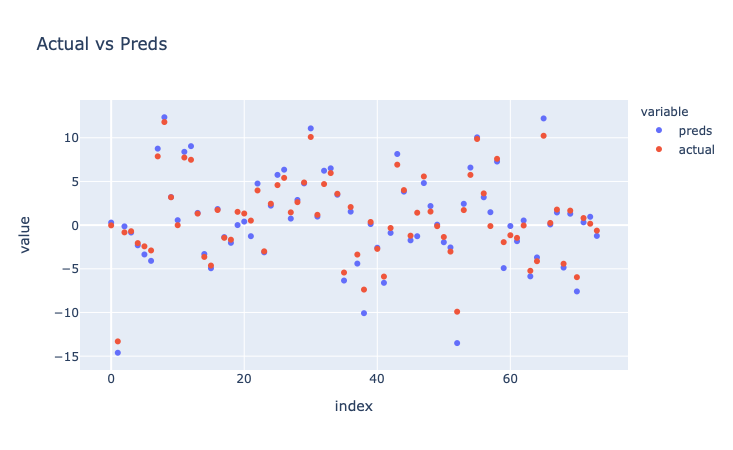

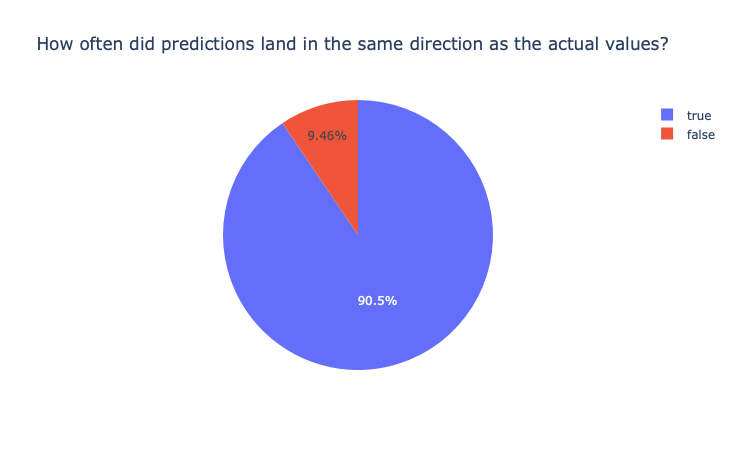

In [437]:
# Visualizing results
fig = px.scatter(
    compare,
    x=compare.index,
    y=['preds', 'actual'],
    title='Actual vs Preds'
)

fig.show()

fig = px.pie(
    dir_df,
    names=dir_df.index,
    values=dir_df['same_direction'],
    title='How often did predictions land in the same direction as the actual values?'
)

fig.show()

# 4. Backtesting Linear Regression

In [457]:
def fitModel(new_df):
    
    # Column name
    col_name = new_df.columns[-1]

    # Variables
    X = new_df.drop(col_name, axis=1)

    y = new_df[[col_name]]
    
    # Model object
    reg = LinearRegression()

    # Fitting
    reg.fit(X, y)
    
    return reg